In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prepare for Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset.data.shape)
print(testset.data.shape)
print(len(trainset.data))

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000


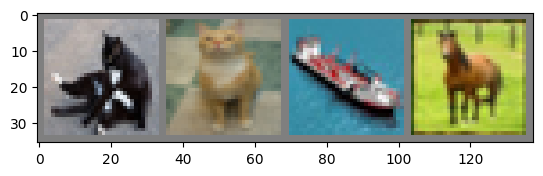

torch.Size([4, 3, 32, 32])
  cat   cat  ship horse


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))

print(images.size())
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [43]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

mps


#### Network Definition

In [44]:
class AvgNet(nn.Module):
    def __init__(self):
        super(AvgNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

avg_net = AvgNet()     # Create the network instance.
avg_net.to(device)  # Move the network parameters to the specified device.

AvgNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Optimizer and Loss Function

In [45]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(avg_net.parameters(), lr=0.001, momentum=0.9)

#### Training Procedure

In [46]:
avg_train_losses = []   # Avg. losses.
train_accuracies, test_accuracies = [], []  # Train and test accuracies.

epochs = 10       # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    train_running_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = avg_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        train_running_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Record both training and testing loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = train_running_loss / record_freq
            avg_train_losses.append(avg_train_loss)
            train_running_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
                
    # Set the model to evaluation mode.
    avg_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = avg_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    # Set the model back to training mode.
    avg_net.train()     

            
print('Finished Training.')

# save model
PATH = './cifar_avg_net_sgd.pth'
torch.save(avg_net.state_dict(), PATH)  

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.897
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.660
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.588
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.533
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.432
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.399
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.391
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.248
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.212
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.245
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.073
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.188
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.230
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.220
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.070
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

#### Training Loss Curve

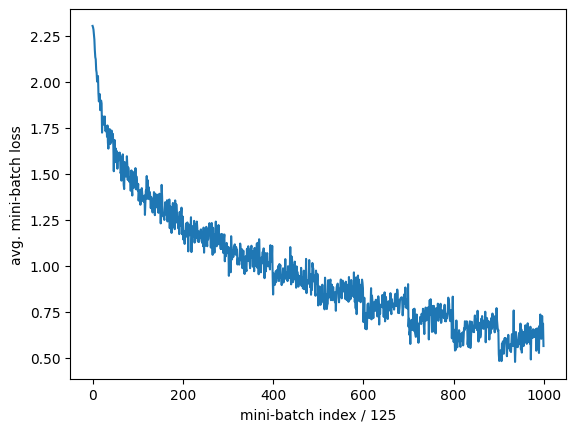

In [47]:
plt.plot(avg_train_losses)
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

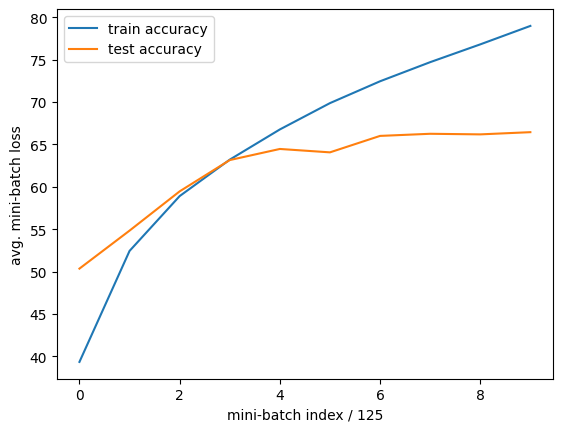

In [48]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

#### Evaluate on Test Dataset

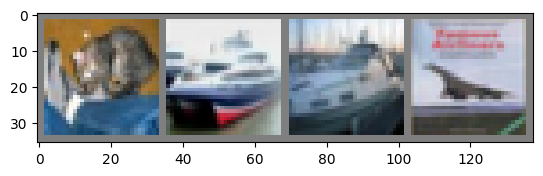

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [49]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = avg_net(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [93]:
avg_net.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = avg_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64.42 %


In [51]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = avg_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 63 %
Accuracy of   cat : 43 %
Accuracy of  deer : 59 %
Accuracy of   dog : 51 %
Accuracy of  frog : 73 %
Accuracy of horse : 68 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %
